**COMP41680: Data Science in Python<br>**
**Assignment 2<br>**

Name: **Kunal J. Tolani**<br>
Student ID: **19200153**

## Imports

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Get Data

For the data, we scrape through http://mlg.ucd.ie/modules/yalp/ to fetch reviews of each businesses in three categories - Cafes, Hotels and Restaurants. The reviews are divided into positive and negative based on the number of stars they have.

### Create DataFrames

In [2]:
#Create dataframes for the three categories

cafes_df = pd.DataFrame(columns=["Review","Label"])
hotels_df = pd.DataFrame(columns=["Review","Label"])
restaurants_df = pd.DataFrame(columns=["Review","Label"])

#Create a list of dataframes to append to later
df_list = [cafes_df,hotels_df,restaurants_df]

### Scraping data
`get_category_urls()` functions is passed three categories, and it returns the urls for each of those. These urls are then passed on to the `get_reviews()` function, which goes through each url and gets positive and negative reviews for each business in each URL.

In [3]:
def get_category_urls(three_categories = ["Cafes","Hotels","Restaurants"]):
    url = "http://mlg.ucd.ie/modules/yalp/"  #url to fetch
    response = get(url) #get response
    html_soup = BeautifulSoup(response.text , 'html.parser') #create soup object
    categories = html_soup.find_all("h4") #Find all h4 tags on the page
    url_cat = [] #list to store urls
    for cat in categories:  #for each h4 tag
        category = cat.find('a').text.split(" ")[1]  #get category name
        if category in three_categories: #if category in three specified categories
            url_cat.append(url+cat.find('a')['href'])  #add url to list
    return url_cat  #return category url list

In [4]:
def get_reviews(url_cat, df_list):  #Pass the category url list 
    url = "http://mlg.ucd.ie/modules/yalp/"
    i = 0
    for new_url in url_cat:  #For each category
        url_response = get(new_url)  #Get response
        html_cat_soup = BeautifulSoup(url_response.text, 'html.parser')  #create soup object
        for business in html_cat_soup.find_all("h5"):  #For each business in category
            reviews_response=get(url+business.find('a')['href'])  #find urls of each business
            reviews_soup = BeautifulSoup(reviews_response.text , 'html.parser')  #create soup object for each business
            j = 0
            for t in reviews_soup.find_all('img', alt=True): #get all reviews 
                rev_num = int(t['alt'].split("-")[0]) #get number of stars from alt of image
                rev = reviews_soup.find_all('p', class_='review-text')[j].text #get image text
                if rev_num > 3:
                    list_append = [rev,"Positive"] #Positive if stars more than 3
                else:
                    list_append = [rev,"Negative"]  #Else negative review
                s = pd.Series(list_append, index=df_list[i].columns)
                df_list[i] = df_list[i].append(s, ignore_index=True)  #add to dataframe
                
                j+=1
        i+=1
            

In [5]:
url_cat = get_category_urls()  #get urls
get_reviews(url_cat, df_list)  #get reviews and label

In [6]:
#Create three separate dataframes

cafes_df = df_list[0]
hotels_df = df_list[1]
restaurants_df = df_list[2] 

In [28]:
#Reading from csv for future-proofing

cafes_df=pd.read_csv("cafes.csv")
hotels_df=pd.read_csv("hotels.csv")
restaurants_df=pd.read_csv("restaurants.csv")

In [8]:
cafes_df.to_csv("cafes.csv", index=False)
hotels_df.to_csv("hotels.csv", index=False)
restaurants_df.to_csv("restaurants.csv", index=False)

The DataFrames for each Category is of the form:

In [29]:
print("Cafes DF:")
display(cafes_df.head())
print("Hotels DF:")
display(hotels_df.head())
print("Restaurants DF:")
display(restaurants_df.head())

Cafes DF:


Review     Label
0  Pros: Lots of items you would not expect from ...  Positive
1  Best egg-tarts in town! There's really not muc...  Positive
2  I've been to ABC Bakery a few times since I re...  Negative
3  FYI, Closed Monday's New ownership for about 1...  Negative
4  The inside may not look like much but they mak...  Positive

Hotels DF:


Review     Label
0  Melissa took us on a tour of Asia in the space...  Positive
1  With a group of seven of us visiting Montreal ...  Positive
2  Melissa is a gem! My fiancÃ© found her tour on...  Positive
3  A perfect day in Montreal! Melissa outfitted u...  Positive
4  I had a really great food truck tour with Meli...  Positive

Restaurants DF:


Review     Label
0  My husband and I had a rare afternoon off so w...  Negative
1  For years I thought this was only a wine store...  Positive
2  This place is so charming! I went with my husb...  Positive
3  We have been wanting to try this place for a c...  Positive
4  Decor looks ok but layout is too busy. Difficu...  Negative

## Preprocessing and cleaning up textual data

For **preprocessing**, we perform the following steps:
* **Tokenization** - seperate the sentences into tokens
* Removal of **punctuations.**
* Removing **stopwords.**
* **Normalization** - ensuring all tokens are lowercase
* **POS tagging** and converting POS tags to **WordNet** form - tagging every token with a part of speech - this will be essential for lemmatization
* **Lemmatization** - Finding lemmas in the dictionary and grouping together words with same lemma / root. 

In [10]:
#preprocess and return lemmatized strings

def preprocess_dfs(df):   
    stop = set(stopwords.words('english')) #english stopwords

    #seperate x and y
    X_df = df['Review']
    y_df = df['Label']

    X_list = list(df['Review'])

    #tokenization
    tokens = []
    for review in X_list:
        review = review.translate(review.maketrans('', '', string.punctuation))
        tokens.append(nltk.word_tokenize(review))

    #remove stopwords and normalize
    pos_tokens = []
    for docs in range(len(tokens)):
        tokens[docs] = [w.lower() for w in tokens[docs]]
        tokens[docs] = [w for w in tokens[docs] if w not in stop]
        pos_tokens.append(nltk.pos_tag(tokens[docs]))

    #get wordnet tags
    def convert_tags_to_wordnet(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return 'a'
        elif tag.startswith('R'):
            return 'r'
        elif tag.startswith('N'):
            return 'n'
        else:
            return None

    #lemmatization
    lemma = nltk.WordNetLemmatizer()
    lemmatized_words = []

    for token in pos_tokens:
        w = []
        for word in token:
            converted_tag = convert_tags_to_wordnet(word[1])
            if(converted_tag is not None):
                out = lemma.lemmatize(word[0],converted_tag)
                w.append(out)
        lemmatized_words.append(w)

    #covert list of tokens to strings
    seperator = ' '
    for words in range(len(lemmatized_words)):
        lemmatized_words[words] = seperator.join(lemmatized_words[words])
    
    y_df = [1 if y=='Positive' else 0 for y in list(y_df)]
    
    return (lemmatized_words, pd.Series(y_df))
    

In [11]:
(cafes_lemma, y_cafe) = preprocess_dfs(cafes_df)
(hotels_lemma, y_hotel) = preprocess_dfs(hotels_df)
(restaurants_lemma, y_restaurant) = preprocess_dfs(restaurants_df)

The output of preprocessing is a list of reviews for each category - with stopwords removed and words lemmatized.

In [12]:
cafes_lemma[:5]

['pro lot item expect chinese bakery friendly owner great value con service slow busy read previous review apparently owner place change recently never experienced place previous owner base review abc standard chinese bakery lot hot food order well always see place come plaza dim sum look small outside there large amount table space come abc item expect chinese bakery breakfast couple combos great value ion opinion get combo include beef brisket noodle egg sandwich large cold milk tea beef brisket noodle great amount brisket good amount veggie boot normally get veggie love owner seem pa type ownership nice friendly english use work try hard get understanding dont speak chinese seem work front kitchen staff back get super busy expect wait time im really glad decide try place see come instead dont want wait dim sum support local business straight business support',
 'best eggtarts town theres really much say hong kong style fastfood restaurant dont come customer service dont come luxurio

## Identify optimal classifier

Here, we use all three datasets to identify which classifier to use for further processing. Each dataset is vectorized into train and validation set individually, and all three classifiers are run on the same set.

In [13]:
#run all classifiers and compare the three
def run_classifiers(xa,ya):
    
    vectorizer=TfidfVectorizer(stop_words="english",min_df = 10)
    tfidf_train = vectorizer.fit_transform(xa)
    xa = pd.DataFrame(tfidf_train.todense(), columns=vectorizer.get_feature_names())
    
    classifiers = [RandomForestClassifier(), MultinomialNB(), LogisticRegression()] #list classifiers
    x_train, x_test, y_train, y_test = train_test_split(xa,ya, train_size=0.7) #split into train and test
    results = pd.DataFrame(columns=['classifier','fp_rate','tp_rate','auc','accuracy'])
    
    for clf in classifiers: #for each classifier
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_proba = clf.predict_proba(x_test)
        
        fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
        roc_auc = auc(fpr, tpr)
        results = results.append({'classifier':clf.__class__.__name__,
                                 'fp_rate':fpr, 'tp_rate':tpr,'auc':roc_auc,
                                 'accuracy':accuracy_score(y_test,y_pred)}, ignore_index=True)
        print(str(clf.__class__.__name__)+": ")
        print(confusion_matrix(y_test,y_pred))
        
    results.set_index('classifier', inplace=True)

    fig = plt.figure(figsize=(8,6))
    
    for res in results.index:
        plt.plot(results.loc[res]['fp_rate'], results.loc[res]['tp_rate'], label="{}, AUC={:.3f}".format(res, results.loc[res]['auc']))
        print(str(res)+ " accuracy: " + str(results.loc[res]['accuracy']))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=1.1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic', fontweight='bold')
    plt.legend()
    plt.show()

**All classifiers on cafe data:**

RandomForestClassifier: 
[[ 76 106]
 [ 10 408]]
MultinomialNB: 
[[ 52 130]
 [  4 414]]
LogisticRegression: 
[[ 64 118]
 [  4 414]]
RandomForestClassifier accuracy: 0.8066666666666666
MultinomialNB accuracy: 0.7766666666666666
LogisticRegression accuracy: 0.7966666666666666


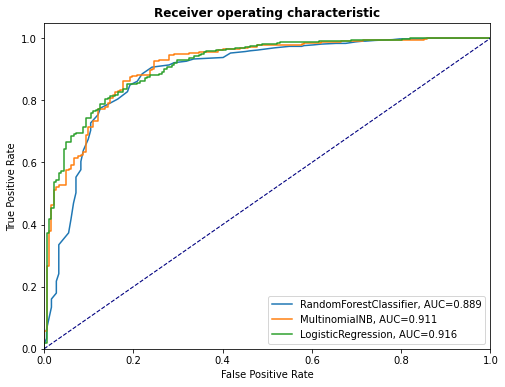

In [14]:
run_classifiers(cafes_lemma, y_cafe)

**All classifiers on hotel data:**

RandomForestClassifier: 
[[201  48]
 [ 20 331]]
MultinomialNB: 
[[197  52]
 [ 17 334]]
LogisticRegression: 
[[204  45]
 [ 24 327]]
RandomForestClassifier accuracy: 0.8866666666666667
MultinomialNB accuracy: 0.885
LogisticRegression accuracy: 0.885


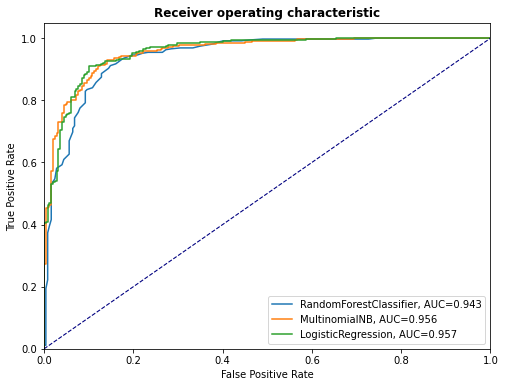

In [15]:
run_classifiers(hotels_lemma, y_hotel)

**All classifiers on Restaurant Data:**

RandomForestClassifier: 
[[194  63]
 [ 34 309]]
MultinomialNB: 
[[186  71]
 [ 13 330]]
LogisticRegression: 
[[197  60]
 [ 18 325]]
RandomForestClassifier accuracy: 0.8383333333333334
MultinomialNB accuracy: 0.86
LogisticRegression accuracy: 0.87


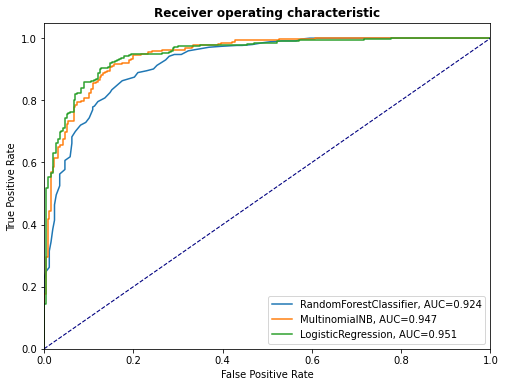

In [16]:
run_classifiers(restaurants_lemma, y_restaurant)

 All three classifiers - RandomForect, MultinomialNB and LogisticRegression, perform well on individual datasets. Logisitc Regression and Multinomial NB performed similarly, with LR giving slightly higher performance. For the rest of the project, ***Logistic Regression*** is used.

## Evaluating the performance of Logistic Regression Model 
**When trained on one category and applied to the other two categories.**

`vectorize_train_test()` - Function to prepare the train and test datasets - the datasets are vectorised to form tf-idf vector datasets. We use fit and transform on the train dataset to fit the vectorizer, and then transform the two test datasets according to the trained data features. This ensures that features of train and test data are identical for classification.

In [17]:
#Prepare train and test datasets - convert database of sentences to tf-idf vectors

def vectorize_train_test(lem_train, lem_test1, lem_test2):
    
    vectorizer=TfidfVectorizer(stop_words="english",min_df = 10) #Initialize vectorizer
    tfidf_train = vectorizer.fit_transform(lem_train) #Fit and transform on train dataset
    X_tfidf_train = pd.DataFrame(tfidf_train.todense(), columns=vectorizer.get_feature_names())
    
    tfidf_test1 = vectorizer.transform(lem_test1) #Transform test dataset according to the train data
    X_tfidf_test1 = pd.DataFrame(tfidf_test1.todense(), columns=vectorizer.get_feature_names())
    
    tfidf_test2 = vectorizer.transform(lem_test2) #Transform test dataset according to the train data
    X_tfidf_test2 = pd.DataFrame(tfidf_test2.todense(), columns=vectorizer.get_feature_names())

    return X_tfidf_train, X_tfidf_test1, X_tfidf_test2 #Return the train and testing datasets


`run_logistic_regression()` - Function to perform logistic regression. We use grid search to find the best solver for the dataset, and using the best model train and test the model.

In [18]:
def run_logistic_regression(xa, xb, xc, ya, yb, yc):
    
    #xa is the training data, xb and xc are test datasets
    
    #Using gridsearch to identify best model for training data
    clf = LogisticRegression()
    params_grid = [{'solver':['newton-cg','saga','sag','lbfgs'],
                   'n_jobs':[-1]}]

    my_tuned_model = GridSearchCV(clf, params_grid, verbose = 2, n_jobs=-1)
    my_tuned_model.fit(xa, ya)

    print("Best score and params:")
    print(my_tuned_model.best_score_)
    print(my_tuned_model.best_params_)
    
    #Fit best model on train data
    best_model = my_tuned_model.best_estimator_
    best_model.fit(xa,ya)
    
    #Predict positive or negative on other two datasets using the best model
    y_predict_b = best_model.predict(xb)
    y_predict_c = best_model.predict(xc)
    
    #Return accuracy scores and outputs
    return y_predict_b, y_predict_c

Using this function, we train on one dataset, and test on the other two. 

### Train on Cafes, Test on Hotels and Restaurants

In [19]:
X_cafe_train, X_hotel_test, X_restaurant_test = vectorize_train_test(cafes_lemma, hotels_lemma, restaurants_lemma)
y_pred_hotel, y_pred_restaurant = run_logistic_regression(X_cafe_train, X_hotel_test, X_restaurant_test, y_cafe, y_hotel, y_restaurant)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.2s finished


Best score and params:
0.8414999999999999
{'n_jobs': -1, 'solver': 'newton-cg'}


**Hotel data report:**

In [20]:
print(classification_report(y_hotel, y_pred_hotel))
print(confusion_matrix(y_hotel, y_pred_hotel))

              precision    recall  f1-score   support

           0       0.87      0.65      0.74       824
           1       0.79      0.93      0.86      1176

    accuracy                           0.82      2000
   macro avg       0.83      0.79      0.80      2000
weighted avg       0.82      0.82      0.81      2000

[[ 538  286]
 [  83 1093]]


**Restaurant data report:**

In [21]:
print(classification_report(y_restaurant, y_pred_restaurant))
print(confusion_matrix(y_hotel, y_pred_hotel))

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       838
           1       0.78      0.96      0.86      1162

    accuracy                           0.82      2000
   macro avg       0.85      0.80      0.81      2000
weighted avg       0.84      0.82      0.81      2000

[[ 538  286]
 [  83 1093]]


### Train on Hotels, Test on Cafes and Restaurants

In [22]:
X_hotel_train, X_cafe_test, X_restaurant_test = vectorize_train_test(hotels_lemma, cafes_lemma, restaurants_lemma)
y_pred_cafe, y_pred_restaurant = run_logistic_regression(X_hotel_train, X_cafe_test, X_restaurant_test, y_hotel, y_cafe, y_restaurant)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.1s finished


Best score and params:
0.884
{'n_jobs': -1, 'solver': 'newton-cg'}


**Cafe data report:**

In [23]:
print(classification_report(y_cafe, y_pred_cafe))
print(confusion_matrix(y_cafe, y_pred_cafe))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       538
           1       0.86      0.95      0.90      1462

    accuracy                           0.85      2000
   macro avg       0.84      0.77      0.79      2000
weighted avg       0.85      0.85      0.84      2000

[[ 312  226]
 [  70 1392]]


**Restaurant data report:**

In [24]:
print(classification_report(y_restaurant, y_pred_restaurant))
print(confusion_matrix(y_restaurant, y_pred_restaurant))

              precision    recall  f1-score   support

           0       0.86      0.66      0.74       838
           1       0.79      0.92      0.85      1162

    accuracy                           0.81      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.82      0.81      0.81      2000

[[ 550  288]
 [  91 1071]]


### Train on Restaurants, Test on Cafes and Hotels

In [25]:
X_restaurant_train, X_hotel_test, X_cafe_test = vectorize_train_test(restaurants_lemma, hotels_lemma, cafes_lemma)
y_pred_hotel, y_pred_cafe = run_logistic_regression(X_restaurant_train, X_hotel_test, X_cafe_test, y_restaurant, y_hotel, y_cafe)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


Best score and params:
0.851
{'n_jobs': -1, 'solver': 'newton-cg'}


**Hotel data report:**

In [26]:
print(classification_report(y_hotel, y_pred_hotel))
print(confusion_matrix(y_hotel,y_pred_hotel))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       824
           1       0.90      0.84      0.87      1176

    accuracy                           0.85      2000
   macro avg       0.84      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

[[709 115]
 [189 987]]


**Cafe data report:**

In [27]:
print(classification_report(y_cafe, y_pred_cafe))
print(confusion_matrix(y_cafe,y_pred_cafe))

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       538
           1       0.91      0.93      0.92      1462

    accuracy                           0.88      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000

[[ 399  139]
 [ 105 1357]]


## Summary and Conclusion

We used the bs4 package to scrape review data from a website from three categories. This textual data was then preprocessed using various text pre-processing techniques including stopword-removal, normalization and lemmatization.

Then, we used trained and tested three models on each of the three category datasets, and concluded that Logistic Regression performed the best of those, with accuracies of 79.6%, 88.5% and 87% on cafe, hotel and restaurant data respectively.

For the next task, we trained the **logistic regression** model on one category, and classified the data of the other two categories. 

For this task, our data needs to be preprocessed and the shape of features in all three datasets needs to be identical. Initally, I did this by combining the datasets and preprocessing then together, and then seperating into different categories. This was later changed into the current method of using the **vectorizer's transform function** to shape the test data according to the train data - which gave slightly better results than the previous method.

Training on **cafe data**, we see similar accuracies of **82%** when the hotel and restaurant data is classified.

Training on **hotel data**, we see an accuracy of **85% with cafes**, and **81% with restaurants.**

Training on **restaurant data**, we see an accuracy of **85% with hotels**, and **88% with cafes**.

There is a **slight bias towards positive ratings** in each model. This is expected as we have not accounted for bias in the dataset while classification.

The accuracies of each model lie in a similar range, this might be because all three categories - cafes, restaurants and hotels are pretty similar, so the review text would contain a lot of the same words. This might be different across **different domains**.
